# Variational inference using the finite approximation

trying standard cavi

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [2]:
np.random.seed(5464) 
Num_samples = 500 # sample size

D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)
print(Pi)

[ 0.8  0.8  0.8]


In [3]:
"""np.random.seed(43141) 

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP


alpha = 10 # IBP parameter
Pi = np.ones(K_inf) * .8
Z = np.zeros([Num_samples,K_inf])

# Parameters to draw A from MVN
mu = np.zeros(D)
sigma_A = 100

sigma_eps = .1 # variance of noise

# Draw Z from truncated stick breaking process
for k in range(K_inf):
    # Pi[k] = np.random.beta(alpha/K_inf,1)
    for n in range(Num_samples):
        Z[n,k] = np.random.binomial(1,Pi[k])

        
print('true Z (first 10 rows): \n', Z[0:10,:])

# Draw A from multivariate normal
# A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf) # FOR SOME REASONG THIS KILLS THE KERNEL!?
A = np.random.normal(0, np.sqrt(sigma_A), (K_inf, D))
print(A)

# draw noise
# epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)
epsilon = np.random.normal(0, sigma_eps, (Num_samples, D))

# the observed data
X = np.dot(Z,A) + epsilon
"""

"np.random.seed(43141) \n\nNum_samples = 500 # sample size\nD = 2 # dimension\n# so X will be a N\times D matrix\n\nK_inf = 3 # take to be large for a good approximation to the IBP\n\n\nalpha = 10 # IBP parameter\nPi = np.ones(K_inf) * .8\nZ = np.zeros([Num_samples,K_inf])\n\n# Parameters to draw A from MVN\nmu = np.zeros(D)\nsigma_A = 100\n\nsigma_eps = .1 # variance of noise\n\n# Draw Z from truncated stick breaking process\nfor k in range(K_inf):\n    # Pi[k] = np.random.beta(alpha/K_inf,1)\n    for n in range(Num_samples):\n        Z[n,k] = np.random.binomial(1,Pi[k])\n\n        \nprint('true Z (first 10 rows): \n', Z[0:10,:])\n\n# Draw A from multivariate normal\n# A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf) # FOR SOME REASONG THIS KILLS THE KERNEL!?\nA = np.random.normal(0, np.sqrt(sigma_A), (K_inf, D))\nprint(A)\n\n# draw noise\n# epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)\nepsilon = np.random.normal(0, si

# set initializations

In [4]:
# set initializations
K_approx = deepcopy(K_inf) # variational truncation
tau, nu, phi_mu, phi_var = initialize_parameters(Num_samples, D, K_approx)

Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}

iterations = 1000
elbo = np.zeros(iterations)

"""print(X[0:10,:])
print(tau)
print(phi_mu)
print(nu[0:10,:])
"""


'print(X[0:10,:])\nprint(tau)\nprint(phi_mu)\nprint(nu[0:10,:])\n'

In [5]:
"""K_approx = deepcopy(K_inf) # variational truncation

tau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v
#tau = np.ones([K_approx,2])*1000
#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi

#nu = np.ones([Num_samples, K_approx]) *0.0
nu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)

phi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = np.ones(K_approx)

nu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

iterations = 1000
elbo = np.zeros(iterations)
elbo_Term1 = np.zeros(iterations)
elbo_Term2 = np.zeros(iterations)
elbo_Term3 = np.zeros(iterations)
elbo_Term4 = np.zeros(iterations)
elbo_Term5 = np.zeros(iterations)
elbo_Term6 = np.zeros(iterations)
elbo_Term7 = np.zeros(iterations)


Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': 100, 'A': sigma_A}
"""

"K_approx = deepcopy(K_inf) # variational truncation\n\ntau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v\n#tau = np.ones([K_approx,2])*1000\n#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi\n\n#nu = np.ones([Num_samples, K_approx]) *0.0\nnu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk\n#nu = deepcopy(Z)\n\nphi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column\n#phi_mu = deepcopy(A).T\nphi_var = np.ones(K_approx)\n\nnu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)\n\niterations = 1000\nelbo = np.zeros(iterations)\nelbo_Term1 = np.zeros(iterations)\nelbo_Term2 = np.zeros(iterations)\nelbo_Term3 = np.zeros(iterations)\nelbo_Term4 = np.zeros(iterations)\nelbo_Term5 = np.zeros(iterations)\nelbo_Term6 = np.zeros(iterations)\nelbo_Term7 = np.zeros(iterations)\n\n\nData_shape = {'D':D, 'N': Num_samples , 'K':K_approx}\nsigmas = {'eps': 100, 'A': sigma_A}\n"

In [6]:
def add_noise_to_phi(phi_mu, noise_scale):
    phi_mu[:] = phi_mu + np.random.normal(0, noise_scale, phi_mu.shape)

print(phi_mu)
add_noise_to_phi(phi_mu, 100)
print(phi_mu)

[[ 2.03278815  0.84803042 -0.46536995]
 [-0.03470319  0.31101153  0.00839046]]
[[ -43.99305053  -58.53631528    6.13965046]
 [-147.31295718  -75.95956828   69.89306729]]


# run CAVI

In [7]:
 for i in range(iterations):
    iter_ran = i + 1
    
    """    phi_mu_old = deepcopy(phi_mu)
    phi_var_old = deepcopy(phi_var)
    tau_old = deepcopy(tau)
    cavi_updates(tau_old, nu, phi_mu_old, phi_var_old, X, alpha, sigmas)
    """
    
    cavi_updates(tau, nu, phi_mu, phi_var, X, alpha, sigmas)
    
    round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

    #[elbo[i],elbo_Term1[i],elbo_Term2[i],elbo_Term3[i],elbo_Term4[i],elbo_Term5[i],elbo_Term6[i],elbo_Term7[i]] \
    #    = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)
    elbo[i] = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)

    print('iteration: ', i, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]), 'elbo: ', elbo[i])
    #print(round_nu[0:10,:])

    if np.isnan(elbo[i]):
        print('NAN ELBO.')
        break

    if (i>0) & (elbo[i] < elbo[i-1]): 
        print('elbo decreased!  Difference: ', elbo[i] - elbo[i-1])
        break

    if np.abs(elbo[i]-elbo[i-1]) <= 10**(-8):
        print('ELBO converged')
        break


456033.731623
-10.49580448
iteration:  0  l1 error:  0.703333333333 elbo:  456023.235819
456033.733707
-10.49580448
iteration:  1  l1 error:  0.703333333333 elbo:  456023.237902
456033.73579
-10.49580448
iteration:  2  l1 error:  0.703333333333 elbo:  456023.239985
456033.737873
-10.49580448
iteration:  3  l1 error:  0.703333333333 elbo:  456023.242069
456033.739956
-10.49580448
iteration:  4  l1 error:  0.703333333333 elbo:  456023.244152
456033.742039
-10.49580448
iteration:  5  l1 error:  0.703333333333 elbo:  456023.246235
456033.744122
-10.49580448
iteration:  6  l1 error:  0.703333333333 elbo:  456023.248318
456033.746205
-10.49580448
iteration:  7  l1 error:  0.703333333333 elbo:  456023.2504
456033.748288
-10.49580448
iteration:  8  l1 error:  0.703333333333 elbo:  456023.252483
456033.750371
-10.49580448
iteration:  9  l1 error:  0.703333333333 elbo:  456023.254566
456033.752453
-10.49580448
iteration:  10  l1 error:  0.703333333333 elbo:  456023.256649
456033.754536
-10.49580

Z (unpermuted): 
 [[1 0 0]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 0]
 [1 1 0]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 0]]
** procedure did not give a true permutation
permutation:  [1, 2, 0]
Z (permuted) 
 [[0 0 1]
 [1 1 1]
 [1 1 1]
 [1 0 1]
 [1 0 1]
 [1 0 1]
 [1 1 1]
 [1 1 1]
 [1 0 1]
 [1 0 1]]
round_nu 
 [[ 1.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 1.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]
 [ 0.  0.  0.]]
l1 error (after permutation):  [0.57599999999999996, 0.44800000000000001, 0.93999999999999995]


true A (permuted): 
 [[ 14.49575873 -10.10045375]
 [ 22.32924855   2.35520426]
 [ -0.22002195  -3.29383694]]
phi_mu: 
 [[-22.91118831  -0.36327817]
 [ 36.58748702 -10.78588522]
 [  0.           0.        ]]


true Pi (permuted):  [ 0.94082118  0.88079276  0.40637588]
computed Pi:  [ 0.49636484  0.80568407  0.00660939]


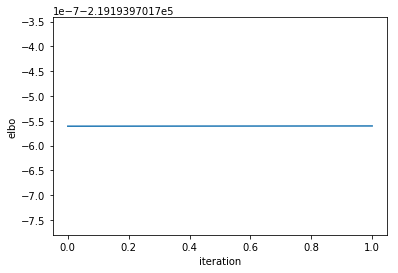

In [83]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [1,2,0]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

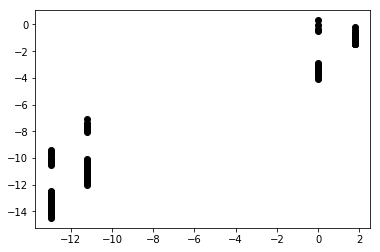

In [65]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 1
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()

In [90]:
x = np.random.beta(1,1, 1000)
print(np.mean(np.log(x)))
print(np.mean(np.log(1-x)))

-0.998160062621
-0.973580314843
